# 0. Imports

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [37]:
RND_STATE_SEED = 42

<IPython.core.display.Javascript object>

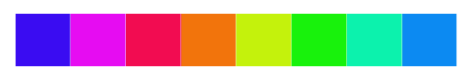

<IPython.core.display.Javascript object>

In [67]:
import toolz as fp
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import gc

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
palette = sns.hls_palette(8, h=0.7, s=0.9, l=0.5)
sns.palplot(palette)
sns.set_palette(palette)

gray = "444444"

plt.rcParams["figure.facecolor"] = "1"  # background color
plt.rcParams["axes.facecolor"] = "1"  # plot background color

plt.rcParams["grid.color"] = "0.8"
plt.rcParams["grid.alpha"] = 0.4

plt.rcParams["axes.edgecolor"] = "1"

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["grid.linestyle"] = "-"

plt.rcParams["axes.axisbelow"] = True
plt.rcParams["axes.labelcolor"] = gray

plt.rcParams["text.color"] = gray

plt.rcParams["xtick.color"] = gray
plt.rcParams["ytick.color"] = gray
sns.set_style("whitegrid")

# 1. OpenML datasets

In [3]:
import openml
import pandas as pd

openml_df = openml.datasets.list_datasets(output_format="dataframe")[
    [
        "did",
        "name",
        "NumberOfInstances",
        "NumberOfFeatures",
        "NumberOfClasses",
        "NumberOfInstancesWithMissingValues",
    ]
]

<IPython.core.display.Javascript object>

In [4]:
openml_df.head(10)

did             name  NumberOfInstances  NumberOfFeatures  \
2     2           anneal              898.0              39.0   
3     3         kr-vs-kp             3196.0              37.0   
4     4            labor               57.0              17.0   
5     5       arrhythmia              452.0             280.0   
6     6           letter            20000.0              17.0   
7     7        audiology              226.0              70.0   
8     8  liver-disorders                NaN               NaN   
9     9            autos              205.0              26.0   
10   10            lymph              148.0              19.0   
11   11    balance-scale              625.0               5.0   

    NumberOfClasses  NumberOfInstancesWithMissingValues  
2               5.0                               898.0  
3               2.0                                 0.0  
4               2.0                                56.0  
5              13.0                               384.0  
6              26.0                                 0.0  
7              24.0                               222.0  
8               NaN                                 NaN  
9               6.0                                46.0  
10              4.0                                 0.0  
11              3.0                                 0.0

<IPython.core.display.Javascript object>

In [5]:
openml_df.shape

(2840, 6)

<IPython.core.display.Javascript object>

## 1.1  Datasets EDA

Count of datasets by number of classes

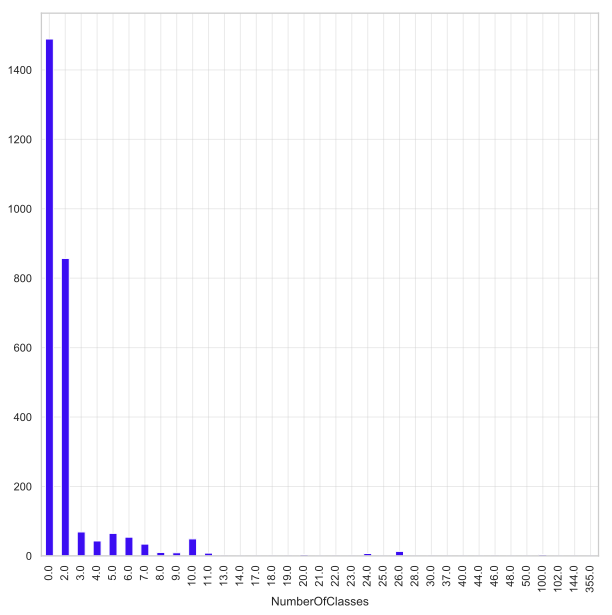

<IPython.core.display.Javascript object>

In [6]:
_, ax = plt.subplots(figsize=(10, 10))
(openml_df.groupby("NumberOfClasses")["did"].count().plot(kind="bar", ax=ax))

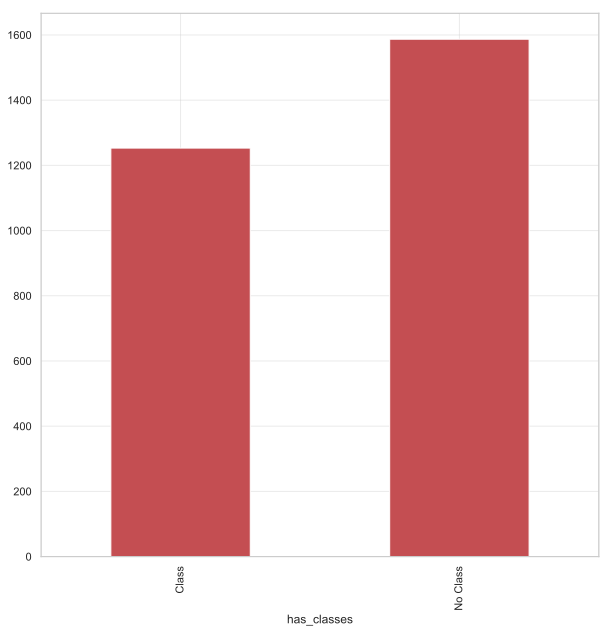

<IPython.core.display.Javascript object>

In [7]:
_, ax = plt.subplots(figsize=(10, 10))
(
    openml_df.assign(
        has_classes=lambda df: np.where(df["NumberOfClasses"] > 0, "Class", "No Class")
    )
    .groupby("has_classes")["did"]
    .count()
    .plot(kind="bar", ax=ax, color="r")
)

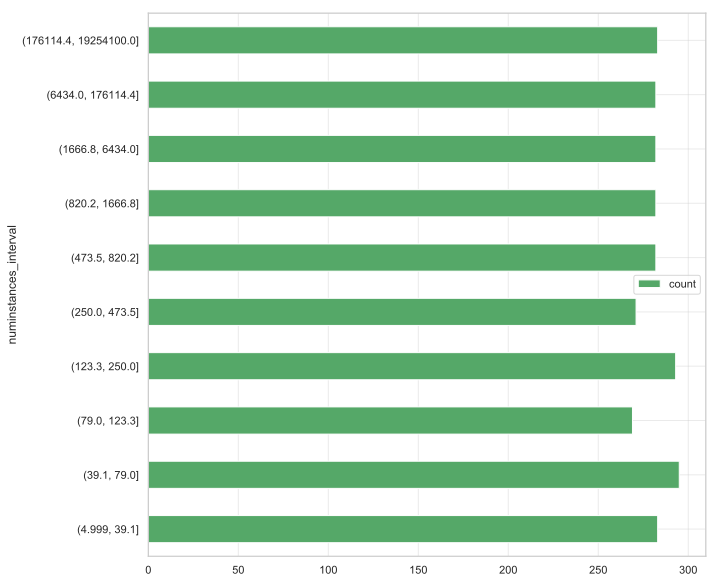

<IPython.core.display.Javascript object>

In [8]:
_, ax = plt.subplots(figsize=(10, 10))
(
    openml_df.assign(
        numinstances_interval=lambda df: pd.qcut(df["NumberOfInstances"].values, q=10)
    )
    .groupby("numinstances_interval")
    .count()
    .reset_index()
    .sort_values(by="numinstances_interval")[["numinstances_interval", "did"]]
    .rename(columns={"did": "count"})
    .plot(kind="barh", ax=ax, x="numinstances_interval", color="g")
)

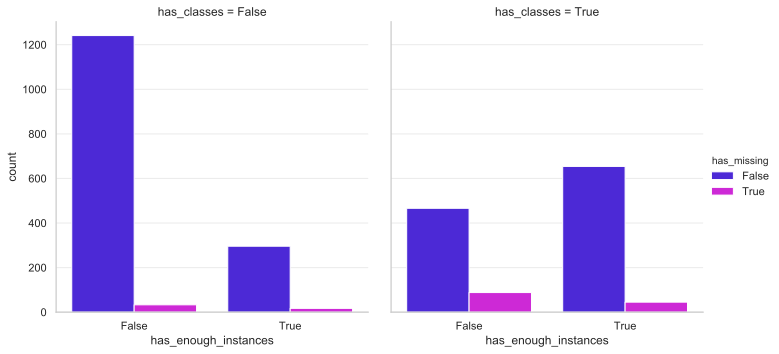

<IPython.core.display.Javascript object>

In [9]:
sns.catplot(
    x="has_enough_instances",
    y="count",
    hue="has_missing",
    col="has_classes",
    kind="bar",
    data=(
        openml_df.assign(
            has_missing=lambda df: df["NumberOfInstancesWithMissingValues"] > 0,
            has_classes=lambda df: df["NumberOfClasses"] > 0.0,
            has_enough_instances=lambda df: df["NumberOfInstances"] > 1000,
        )  # this is arbitrary
        .groupby(by=["has_classes", "has_missing", "has_enough_instances"])
        .count()
        .rename(columns={"did": "count"})
        .reset_index()
    ),
)

## 1.2 Titanic Example

Get metadata

In [16]:
dataset = openml.datasets.get_dataset(
    int(openml_df.query("name == 'Titanic' & NumberOfFeatures == 14")["did"].values[0])
)
target_col_name = "target"
# Print a summary
print(
    "This is dataset '%s', the target feature is '%s'"
    % (dataset.name, dataset.default_target_attribute)
)
print("URL: %s" % dataset.url)
print(dataset.description)

This is dataset 'Titanic', the target feature is 'survived'
URL: https://www.openml.org/data/v1/download/16826755/Titanic.arff
**Author**: Frank E. Harrell Jr., Thomas Cason  
**Source**: [Vanderbilt Biostatistics](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html)  
**Please cite**:   

The original Titanic dataset, describing the survival status of individual passengers on the Titanic. The titanic data does not contain information from the crew, but it does contain actual ages of half of the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. The datasets used here were begun by a variety of researchers. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

Thomas Cason of UVa has greatly updated and improved the titanic data frame using the Encyclopedia Titanica and created the 

<IPython.core.display.Javascript object>

In [39]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute, dataset_format="dataframe"
)
assert X.shape[0] == y.shape[0]
full_dataset = pd.concat(
    (
        X,
        pd.DataFrame(y)
        .astype(int)
        .rename(columns={k: target_col_name for k in [y.name]}),
    ),
    axis=1,
)
assert full_dataset.shape[0] == X.shape[0]
full_dataset.head()

pclass                                             name     sex      age  \
0     1.0                    Allen, Miss. Elisabeth Walton  female  29.0000   
1     1.0                   Allison, Master. Hudson Trevor    male   0.9167   
2     1.0                     Allison, Miss. Helen Loraine  female   2.0000   
3     1.0             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4     1.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked  boat   body  \
0    0.0    0.0   24160  211.3375       B5        S     2    NaN   
1    1.0    2.0  113781  151.5500  C22 C26        S    11    NaN   
2    1.0    2.0  113781  151.5500  C22 C26        S  None    NaN   
3    1.0    2.0  113781  151.5500  C22 C26        S  None  135.0   
4    1.0    2.0  113781  151.5500  C22 C26        S  None    NaN   

                         home.dest  target  
0                     St Louis, MO       1  
1  Montreal, PQ / Chesterville, ON       1  
2  Montreal, PQ / Chesterville, ON       0  
3  Montreal, PQ / Chesterville, ON       0  
4  Montreal, PQ / Chesterville, ON       0

<IPython.core.display.Javascript object>

In [40]:
np.array(attribute_names)[categorical_indicator]

array(['sex', 'embarked'], dtype='<U9')

<IPython.core.display.Javascript object>

In [41]:
import toolz as fp
from fklearn.training.exploration import dataset_analyzer

analyzer_fn = dataset_analyzer(
    feature_columns=X.columns,
    target_columns=[target_col_name],
    id_columns=[],
    timestamp_columns=[],
)

<IPython.core.display.Javascript object>

In [42]:
logs = analyzer_fn(full_dataset)
logs.keys()

dict_keys(['parameters', 'statistics', 'warnings'])

<IPython.core.display.Javascript object>

In [43]:
from fklearn.training.exploration import warning_display, statistics_display

warning_display(logs)

<IPython.core.display.Javascript object>

In [44]:
from fklearn.training.exploration import statistics_dict_to_df

df_stats_original = statistics_dict_to_df(logs["statistics"])
df_stats = df_stats_original.drop(
    columns=(
        df_stats_original.T.query("var_type == 'Categorical'")[
            ~df_stats_original.T.query("var_type == 'Categorical'").index.isin(
                np.array(attribute_names)[categorical_indicator]
            )
        ].index.values
    )
)
feature_set = list(df_stats.drop(columns=target_col_name).columns.values)
target = target_col_name
df_stats

pclass          sex       age     sibsp     parch         fare  \
25%                 2           --        21         0         0       7.8958   
50%                 3           --        28         0         0      14.4542   
75%                 3           --        39         1         0       31.275   
cardinality        --            2        --        --        --           --   
count            1309         1309      1046      1309      1309         1308   
dtype         float64     category   float64   float64   float64      float64   
first               1       female        29         0         0      211.338   
freq               --          843        --        --        --           --   
last                3         male        29         0         0        7.875   
max                 3           --        80         8         9      512.329   
mean          2.29488           --   29.8811  0.498854  0.385027      33.2955   
median              3           --        28         0         0      14.4542   
min                 1           --    0.1667         0         0            0   
most_common       3.0         male       nan       0.0       0.0         8.05   
nr_inf              0            0         0         0         0            0   
nr_nan              0            0       263         0         0            1   
perc_inf            0            0         0         0         0            0   
perc_nan            0            0  0.200917         0         0  0.000763942   
skewness    -0.598647           --  0.407672   3.84422   3.66908      4.36771   
std          0.837836           --   14.4135   1.04166   0.86556      51.7587   
top                --         male        --        --        --           --   
unique             --            2        --        --        --           --   
var_type      Numeric  Categorical   Numeric   Numeric   Numeric      Numeric   
variance     0.458365     0.355997  0.799083  0.319328   0.23453     0.954163   

                embarked       body    target  
25%                   --         72        --  
50%                   --        155        --  
75%                   --        256        --  
cardinality            4         --        --  
count               1307        121        --  
dtype           category    float64     int64  
first                  S         --         1  
freq                 914         --        --  
last                   S         --         0  
max                   --        328         1  
mean                  --     160.81  0.381971  
median                --        155         0  
min                   --          1         0  
most_common            S        nan        --  
nr_inf                 0          0         0  
nr_nan                 2       1188         0  
perc_inf               0          0        --  
perc_nan      0.00152788   0.907563        --  
skewness              --  0.0917388        --  
std                   --    97.6969  0.486055  
top                    S         --        --  
unique                 3         --        --  
var_type     Categorical    Numeric   Boolean  
variance        0.301757   0.092437        --

<IPython.core.display.Javascript object>

## 1.3 Train / Split

In [71]:
from sklearn.model_selection import train_test_split

TRAIN_PERCENTAGE = 0.7
x_train, x_test, y_train, y_test = train_test_split(
    full_dataset[feature_set],
    full_dataset[[target]],
    train_size=TRAIN_PERCENTAGE,
    random_state=RND_STATE_SEED,
)
train_set = pd.concat((x_train, y_train), axis=1)
test_set = pd.concat((x_test, y_test), axis=1)

del x_train, x_test, y_train, y_test
gc.collect()

(train_set.shape, test_set.shape)

((916, 9), (393, 9))

<IPython.core.display.Javascript object>

## 1.4 Evaluation metrics

**Binary Classification**

Metrics:
- AUC
- LogLoss
- BrierScore

In [81]:
from fklearn.validation.evaluators import (
    combined_evaluators,
    auc_evaluator,
    logloss_evaluator,
    brier_score_evaluator,
)


def get_eval_fn_binary_classifier(evaluation_target, prediction_column):
    return combined_evaluators(
        evaluators=[
            auc_evaluator(
                target_column=evaluation_target, prediction_column=prediction_column
            ),
            logloss_evaluator(
                target_column=evaluation_target, prediction_column=prediction_column
            ),
            brier_score_evaluator(
                target_column=evaluation_target, prediction_column=prediction_column
            ),
        ]
    )


def get_eval_fn(evaluation_target, prediction_column, model_type):
    if model_type == "BINARY":
        return get_eval_fn_binary_classifier(
            evaluation_target=evaluation_target, prediction_column=prediction_column
        )
    else:
        raise AttributeError("model type is invalid!")

<IPython.core.display.Javascript object>

## 1.5 Titanic training Pipeline

In [82]:
from fklearn.training.pipeline import build_pipeline
from fklearn.training.classification import lgbm_classification_learner
from fklearn.training.transformation import label_categorizer

# TODO: this only works when some feature in the dataset is categorical
lgbm_pipeline = build_pipeline(
    label_categorizer(
        columns_to_categorize=list(
            df_stats.T.query("var_type == 'Categorical'").T.columns.values
        ),
        store_mapping=True,
    ),
    lgbm_classification_learner(
        features=feature_set, target=target_col_name, num_estimators=30
    ),
)

<IPython.core.display.Javascript object>

In [83]:
p, scored, logs = lgbm_pipeline(train_set)

<IPython.core.display.Javascript object>

In [85]:
eval_fn = get_eval_fn(
    evaluation_target=target, prediction_column="prediction", model_type="BINARY"
)
train_result = eval_fn(scored)
train_result

{'auc_evaluator__target': 0.9482402458233273,
 'logloss_evaluator__target': 0.30376828554441343,
 'brier_score_evaluator__target': 0.09175135848777609}

<IPython.core.display.Javascript object>

In [86]:
test_result = eval_fn(p(test_set))
test_result

{'auc_evaluator__target': 0.8896079881656805,
 'logloss_evaluator__target': 0.4252115392820033,
 'brier_score_evaluator__target': 0.13575699375381017}

<IPython.core.display.Javascript object>

## 1.6 Combining everything into a dict

todo:
- build this dict at the end
- make a way to change at will the hyperparameters
-> dataset_id, dataset_name, model_type, number_of_instances, number_of_features (updated after filtering )
